In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm.auto import tqdm
from rl_analysis.plotting import (
    setup_plotting_env,
    clean_ticks,
    savefig,
    clean_plot_labels
)
from rl_analysis.io.df import dlight_exclude
from scipy.stats import norm
from joblib import Parallel, delayed

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

# Helper functions

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
dlight_cfg = analysis_config["dlight_common"]
regression_cfg = analysis_config["dlight_regression"]
lagged_cfg = analysis_config["dlight_lagged_correlations"]
figure_cfg = analysis_config["figures"]

In [5]:
file_suffix = "offline" if lagged_cfg["use_offline"] else "online"
load_file = os.path.join(raw_dirs["dlight"], f"dlight_snippets_{file_suffix}.parquet")

In [6]:
file, ext = os.path.splitext(load_file)
features_save_file = f"{file}_features{ext}"

if lagged_cfg["use_renormalized"]:
    file, ext = os.path.splitext(features_save_file)
    features_save_file = f"{file}_renormalize{ext}"

rle_save_file = features_save_file.replace("snippet", "usage")

In [7]:
use_features = []
for _use_win in lagged_cfg["use_windows"]:
    use_features += [f"{_}_{_use_win}" for _ in lagged_cfg["use_neural_features"]]
scalar_keys = lagged_cfg["usage_and_scalars"]["scalars"]

# Loading in features for correlation

In [8]:
partition_cols = ["area", "mouse_id", "uuid"]

In [9]:
feature_df = pd.read_parquet(features_save_file)
rle_df = pd.read_parquet(rle_save_file)

In [10]:
feature_df[partition_cols] = feature_df[partition_cols].astype("str")
rle_df[partition_cols] = rle_df[partition_cols].astype("str")

In [11]:
feature_df = feature_df.loc[
    (feature_df["duration"] > 0.3) & (feature_df["area"] == "dls")
].copy()
feature_df = dlight_exclude(
    feature_df, exclude_3s=False, syllable_key="syllable", **dlight_cfg
)

In [12]:
feature_df = feature_df.loc[
    feature_df["window"] == pd.Interval(0, 0.3, closed="both")
].copy()

In [13]:
use_features = ["signal_reref_dff_z_max", "velocity_2d_mm_mean"]

In [14]:
syllable_stats = toml.load(
    os.path.join(proc_dirs["dlight"], f"syllable_stats_photometry_{file_suffix}.toml")
)
usage = syllable_stats["usages"]
mapping = {int(k): int(v) for k, v in syllable_stats["syllable_to_sorted_idx"].items()}
reverse_mapping = {
    int(k): int(v) for k, v in syllable_stats["sorted_idx_to_syllable"].items()
}

use_syllables = np.array(list(mapping.keys()))
use_syllables = use_syllables[use_syllables >= 0]

In [15]:
feature_df["syllable"] = feature_df["syllable"].map(mapping)
rle_df["syllable"] = rle_df["syllable"].map(mapping)

In [17]:
rle_df["prev_syllable"] = rle_df.groupby("uuid")["syllable"].shift(+1)

In [18]:
rle_df["syllable_num"] = rle_df.groupby(["uuid"])["syllable"].transform(
    lambda x: np.arange(len(x))
)
feature_df = feature_df.sort_values(["timestamp", "uuid"])
rle_df = rle_df.sort_values(["timestamp", "uuid"])
rle_df["timestamp"] = rle_df["timestamp"].astype("float32")

feature_df["uuid"] = feature_df["uuid"].astype("str")
feature_df = feature_df.drop(["syllable_num", "prev_syllable"], axis=1, errors="ignore")
feature_df = pd.merge_asof(
    feature_df,
    rle_df[["timestamp", "uuid", "syllable_num", "prev_syllable"]],
    on="timestamp",
    by="uuid",
)
feature_df = feature_df.sort_values(["uuid", "timestamp"])
rle_df = rle_df.sort_values(["uuid", "timestamp"])

## Via mutual information

In [19]:
# direct calculation of mutual information
# Args:
#  tm: 2d numpy array of raw transition counts, assumes rows are states and columns are actions
#  alpha: specifies regularization, typical values are between 0-1
#
# Returns:
#  I: mutual information between "states" and "actions"
def plugin_mi_specific_axis(tm, comp_axis=0):
    # potentially want to mask out the diagonal from this calculation, but shouldn't factor since tm_p
    # along the diagonal is 0 by our label definition
    with np.errstate(invalid="ignore", divide="ignore"):

        comp_p = tm.sum(axis=comp_axis)
        comp_p /= comp_p.sum()
        tm_p = tm / tm.sum()

        log_term = np.log(tm_p / np.outer(comp_p, comp_p))
        log_term = np.nan_to_num(log_term, 0, 0, 0)
        mutual_info = np.nansum(tm_p * log_term)
    if ~np.isfinite(mutual_info):
        mutual_info = np.nan
    return mutual_info

In [20]:
norm_by = ["uuid", "syllable"]
group_keys = ["syllable"]

In [21]:
feature_norm = feature_df.groupby(norm_by)[use_features].transform(
    lambda x: (x - x.mean()) / x.std()
)

In [22]:
meta_cols = ["uuid", "mouse_id", "syllable", "prev_syllable"]

In [23]:
use_df = pd.concat([feature_norm, feature_df[meta_cols]], axis=1).dropna()

In [24]:
truncate = syllable_stats["truncate"]

In [25]:
from rl_analysis.info.util import dm_mi
from scipy.stats import norm, invgauss

threshold = norm.ppf(0.975)

In [26]:
use_features = ["signal_reref_dff_z_max", "velocity_2d_mm_mean"]

In [27]:
mi = []
for _feature in use_features:
    rate_matrix = (
        use_df.groupby(["mouse_id", "prev_syllable", "syllable"])[_feature]
        .apply(lambda x: (x > threshold).mean())
        .unstack()
    )
    nanmask = rate_matrix.isnull()
    rate_matrix[nanmask] = 0
    _mi = (
        rate_matrix.groupby("mouse_id")
        .apply(lambda x: dm_mi(x.to_numpy()[:truncate, :truncate], alpha=0))
        .rename(_feature)
    )
    mi.append(_mi)

In [28]:
mi = pd.concat(mi, axis=1)

In [29]:
def compute_shuffle_mi(idx, use_feature=use_features[0]):
    test_df = use_df.copy()
    test_df[use_feature].values[:] = (
        test_df.groupby(["mouse_id", "syllable"])[use_feature].sample(frac=1, random_state=idx).values
    )
    rate_matrix = (
        test_df.groupby(["mouse_id", "prev_syllable", "syllable"])[use_feature]
        .apply(lambda x: (x > threshold).mean())
        .unstack()
    )

    rate_matrix[nanmask] = 0
    mi = (
        rate_matrix.groupby("mouse_id")
        .apply(lambda x: dm_mi(x.to_numpy()[:truncate, :truncate], alpha=0))
        .rename("info")
    )
    mi = mi.reset_index()
    mi["idx"] = idx
    mi["feature"] = use_feature
    return mi

In [30]:
nshuffles = 1000

In [31]:
from functools import partial

all_results = []
for _feature in use_features:
    func = partial(compute_shuffle_mi, use_feature=_feature)
    delays = []
    for i in range(nshuffles):
        delays.append(delayed(func)(i))

    results = Parallel(n_jobs=-1, verbose=10)(delays)
    all_results.append(pd.concat(results))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 429 tasks      | elapsed: 

In [32]:
shuffle_df = pd.concat(all_results).reset_index(drop=True)

In [33]:
_tmp = (
    shuffle_df.groupby(["mouse_id", "idx", "feature"])
    .mean()
    .unstack()
    .droplevel(0, axis=1)
)

In [34]:
shuffle_mu = _tmp.groupby("mouse_id").mean()
shuffle_sig = _tmp.groupby("mouse_id").std()

In [35]:
plt_shuffle = shuffle_df.set_index(["mouse_id", "feature"], append=True)[
    "info"
].unstack()

In [36]:
z_shuffle = (plt_shuffle - shuffle_mu) / shuffle_sig

In [37]:
ci = z_shuffle.abs().quantile(0.95)

In [38]:
z_mi = (mi - shuffle_mu) / shuffle_sig

In [39]:
shuffle_means = (
    shuffle_df.groupby(["idx", "feature"]).mean().unstack().droplevel(0, axis=1)
)

/tmp/ipykernel_1441362/1247421213.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuffle_df.groupby(["idx", "feature"]).mean().unstack().droplevel(0, axis=1)


In [40]:
pvals = (mi.mean() < shuffle_means).mean()

In [41]:
stat_dct = pvals.to_dict()
stat_dct["comparison_type"] = "shuffle test"
stat_dct["n"] = len(z_mi)
stat_dct["n_definition"] = "per syllable mutual information with transition"

In [42]:
with open(
    os.path.join(proc_dirs["dlight"], "dlight_transition_mutual_information.toml"), "w"
) as f:
    toml.dump(stat_dct, f)

In [43]:
aliases = {"signal_reref_dff_z_max": "dLight peak", "velocity_2d_mm_mean": "velocity"}

In [44]:
setup_plotting_env()

In [45]:
z_mi.head()

,signal_reref_dff_z_max,velocity_2d_mm_mean
mouse_id,,
dlight-chrimson-1,1.191940,4.226766
dlight-chrimson-2,1.630386,5.727201
dlight-chrimson-3,0.263171,3.659992
dlight-chrimson-4,1.070301,3.523353
dlight-chrimson-5,2.562807,5.573920


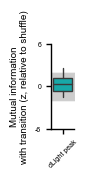

In [46]:
fig, ax = plt.subplots(1, figsize=(.3, 1.1))
sns.boxplot(
    data=z_mi.melt(),
    x="variable",
    order=["signal_reref_dff_z_max"],
    showfliers=False,
    showcaps=False,
    color="c",
    y="value",
)
ax.fill_between(ax.get_xlim(), -ci, +ci, color=[0.8] * 3, zorder=-100)
plt.ylabel("Mutual information\nwith transition (z, relative to shuffle)")
plt.xlabel("")
plt.ylim(-6, 6)
plt.xticks(rotation=45)
sns.despine()
clean_plot_labels(ax, aliases)
clean_ticks(ax, "y", precision=0, dtype=int, zero_symmetry=False)
savefig(
    fig,
    os.path.join(
        figure_cfg["store_dir"], "dlight_transition_analysis_mutual_information"
    ),
    bbox_inches="tight",
)

In [47]:
pvals

feature
signal_reref_dff_z_max    0.165
velocity_2d_mm_mean       0.000
dtype: float64